# NLP based analysis
This is a continuation of the previous notebook, moving on to building an NLP based classifier

# NLP model building (CHECKPOINT)
Devekio a model using just text data, no manual feature engineering of specific "skills" mentioned in text.

In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [2]:
# Import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score 
from sklearn.metrics import plot_roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

## Load in preprocessed data
Read the saved .csv file and tidy things up to suit my classification task.
- I will drop any jobs that aren't data scientist/engineer/analyst or business analyst
- 

In [3]:
df = pd.read_csv('df_preprocessed.csv', index_col=0)
print(f'Data read from .csv\n>> ({len(df)} rows, {len(df.columns)} columns)\n')


Data read from .csv
>> (2422 rows, 58 columns)



In [4]:
# Drop everything but Data Analyst, Data Scientist, Data Engineer, Business Analyst
df = df.drop(df[~df.title_simplified.isin(['data scientist', 
                                           'data analyst', 
                                           'data engineer', 
                                           'business analyst'])].index)
print(f'Dropped rows outside of selection\n>> ({len(df)} rows, {len(df.columns)} columns remaining)')

Dropped rows outside of selection
>> (992 rows, 58 columns remaining)


## Write NLP preprocessing funcs to operate with full df of adverts
Will need to iterate through each row in the df, applying the tokeniser

In [5]:
# Remove stopwords and punctuation
def remove_stopwords_doc(doc):
    # load stopwords and
    stop_words = set(stopwords.words("english"))
    words = [w for w in doc if (w not in stop_words) & (w.isalpha())]
    return words

In [6]:
# loop through each advert
def nlp_pre_process(df, verbose=False):
    '''Loops through each add and tokenizes, removes stopwords, non alphabeticals, '''
    stop_words = set(stopwords.words("english"))
    sent_f_list = []
    
    for index, row in df.iterrows():
        document = row.description.lower()
        document = document.replace('\n',' ')
#         words = nltk.word_tokenize(document)
#         words = [w for w in words if (w not in stop_words) & (w.isalpha())]
#         if verbose: print(f'BEFORE:   "{document[:80]}..."')
#         if verbose: print(f'Number of WORDS: {len(words)}')
        
        # Do the same but on a per-sentence basis.
        # Might eventually put n-grams in this loop.
        sents = nltk.sent_tokenize(document)
        sents = [remove_stopwords_doc(nltk.word_tokenize(sent)) for sent in sents]
        sent_f = []
        for sent in sents:
            sent_f.append(remove_stopwords_doc(sent))
        sent_f = [sent for sents in sent_f for sent in sents]
        word_set = set(sent_f)
        if verbose: print(f'Tokenised:              {sent_f[:10]}...')
        if verbose: print(f'Number of SENTENCES:    {len(sents)}')       
        if verbose: print(f'Number of UNIQUE WORDS: {len(word_set)}\n')
        sent_f_list.append(sent_f)
                        
    return sent_f_list

In [7]:
# Test the func on just 2 job ads first
sent_list = nlp_pre_process(df.head(2), verbose=True)

Tokenised:              ['join', 'us', 'data', 'scientist', 'identifying', 'working', 'large', 'complex', 'data', 'sets']...
Number of SENTENCES:    8
Number of UNIQUE WORDS: 222

Tokenised:              ['client', 'supports', 'international', 'organisations', 'pharmaceutical', 'healthcare', 'industries', 'across', 'range', 'bespoke']...
Number of SENTENCES:    4
Number of UNIQUE WORDS: 112



In [8]:
# Vectorise the tokens to make compatible with classifier training 
def dummy(doc):
    return doc
count_vect = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
X = count_vect.fit_transform(sent_list)

def nlp_vectorize(df, verbose=False):
    sent_list = nlp_pre_process(df, verbose=verbose)
    count_vect = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
    X = count_vect.fit_transform(sent_list)
    return X

In [9]:
# Assign X, y
y = df.title_simplified
X = nlp_vectorize(df)

In [10]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Retry NB model

In [11]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()

In [12]:
clf_nb.fit(X_train, y_train);

In [13]:
# Check accuracy metric
accuracy_score(y_test, clf_nb.predict(X_test))

0.8442211055276382

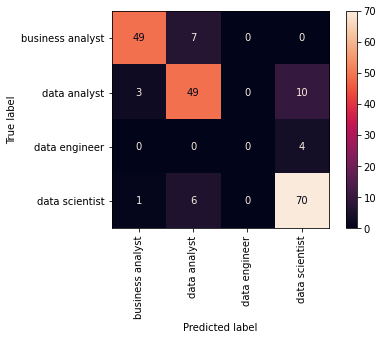

In [14]:
plot_confusion_matrix(clf_nb, X_test, y_test, values_format='d', xticks_rotation='vertical', cmap='rocket');

This result looks disturbingly good
- Have I overfitted?
- Have I made an error?  Is the model classifying the jobs that well? (80%)

Should now do some side-by-side analysis of the results

**But** we don't know whether it's helpful to "balance" the training data, so we need a copy of the model trained 

*NEED TO CHECK WHATs happening with the 

In [15]:
# Oversampling using SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.base import clone

oversample = SMOTE()

X_train_b, y_train_b = oversample.fit_resample(X_train, y_train)
y_train_b.value_counts()

data scientist      275
data analyst        275
business analyst    275
data engineer       275
Name: title_simplified, dtype: int64

In [16]:

def evaluate_clf(clf, X_train, y_train, X_test, y_test, name='Model 1'):
    '''Convenience function for generating metrics
    - clf: sklearn classifier object
    - X:   X for full dataset (before train_test_split)
    - y:   y for full dataset (before train_test_split)'''
        
    # As a diagnostic, print the class imbalance ratios in training set
    unbalanced_ratio = list(y_train.value_counts())
    balanced_ratio = list(y_train_b.value_counts())
    ratio_labels = list(y_train_b.value_counts().index)

    # Set up axes
    fig = plt.figure()
    fig.set_size_inches(10,5)
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title(name)
    
    # Train for both the unbalanced dataset
    clf.fit(X_train, y_train);
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    metrics = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    plot_confusion_matrix(clf, X_test, y_test, values_format='d', xticks_rotation='vertical', 
                          cmap='rocket', ax=ax1, colorbar=False);
    
    # Store results in a "results" dict
    results = dict()
    results['name'] = name
    results['class_ratio'] = unbalanced_ratio
    results['accuracy'] = accuracy
    results['precision'] = metrics[0]
    results['recall'] = metrics[1]
    results['f1'] = metrics[2]
    
    return results

{'name': 'NaiveBayes (no re-balancing)',
 'class_ratio': [275, 238, 237, 43],
 'accuracy': 0.8442211055276382,
 'precision': 0.8288454852880756,
 'recall': 0.8442211055276382,
 'f1': 0.835704249207746}

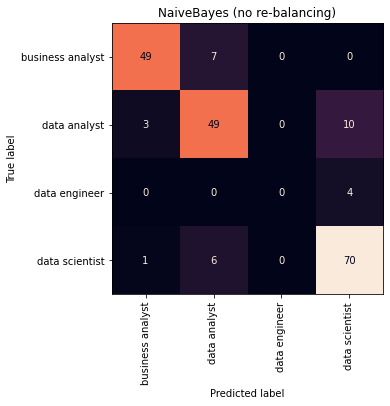

In [17]:
evaluate_clf(clf_nb, X_train, y_train, X_test, y_test, name='NaiveBayes (no re-balancing)', )

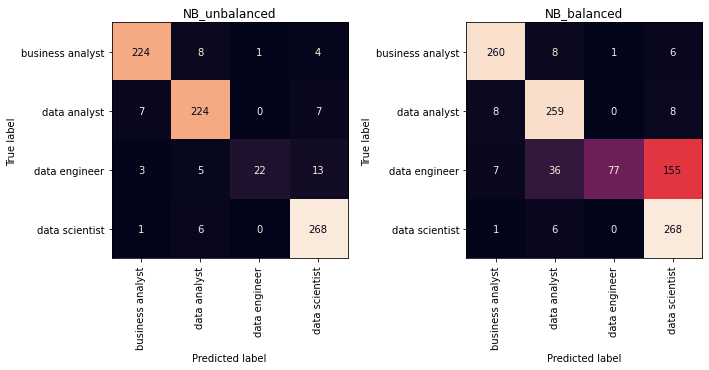

In [18]:
def compare_confusion(clf=None, X=None, y=None, name='Model 1',
                      clf2=None, X2=None, y2=None, name2='Model 2'):
    if any([a is None for a in [clf, clf2, X, X2, y, y2]]):
        raise ValueError('None values entered')
        
    # Set up axes
    fig = plt.figure()
    fig.set_size_inches(10,5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title(name)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title(name2)
    
    # Create plots
    plot_confusion_matrix(clf, X, y, values_format='d', xticks_rotation='vertical', 
                          cmap='rocket', ax=ax1, colorbar=False);
    plot_confusion_matrix(clf2, X2, y2, values_format='d', xticks_rotation='vertical', 
                          cmap='rocket', ax=ax2, colorbar=False);
    fig.tight_layout()
    
    
compare_confusion(clf_nb, X_train, y_train, 'NB_unbalanced',
                 clf_nb, X_train_b, y_train_b, 'NB_balanced')

{'name': 'NaiveBayes (after rebalancing)',
 'class_ratio': [275, 275, 275, 275],
 'accuracy': 0.8492462311557789,
 'precision': 0.8467602624257967,
 'recall': 0.8492462311557789,
 'f1': 0.846636680024669}

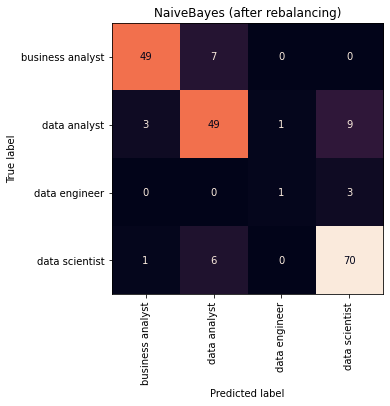

In [19]:
evaluate_clf(clf_nb, X_train_b, y_train_b, X_test, y_test, name='NaiveBayes (after rebalancing)', )

*NEED TO CHECK ABOUT DATA LEAKAGE IF THE ROLE TITLE IS IN THE DESCRIPTION*?